In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.spatial.distance import jensenshannon
from scipy.stats import mannwhitneyu


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

COLORS = [ "#bfef45","#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4","#ffd8b1","#fffac8","#aaffc3",
          "#dcbeff", "#800000","#9A6324","#808000","#469990","#000075","#000000","#e6194B","#f58231","#ffe119",
         ]

MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
def threeAttributes_bar(df, lengend_var, legend_title, y_name, y_label, x_name, x_label, ax, bar_width=0.2, ylimLow=None, ylimHigh = None, title=None, out=False):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    legend_title is the title of the legend
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    title is the title of the plot
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        # fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        ax.set_xlabel(x_label, fontweight='bold')
        ax.set_ylabel(y_label, fontweight='bold')
        ax.set_xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)
        ax.set_title(title)
        ax.set_ylim(ylimLow, ylimHigh)

        # Create legend
        ax.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.15, 1))

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,bar_width=0.3,axes=plt,out=False, ylimLow=None, ylimHigh=None, title=None):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        #fig, axes = plt.subplots( dpi=300, nrows= 1, ncols= 1, figsize=(6, 4))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[0], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        axes.set_ylim(ylimLow, ylimHigh)
        axes.set_yticks(np.round(np.linspace(ylimLow, ylimHigh, 5), 2))
        axes.set_title(title)
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()

def combTwoAttributes_bar(df, y_name_1, y_label_1, y_name_2, y_label_2, y_label_overall, x_name, x_label, bar_width=0.3, axes=plt, out=False, ylimLow=None, ylimHigh=None, title=None):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label_1) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name_1) == str, "y_name is the name of your y column"
    assert type(y_name_2) == str, "y_name is the name of your y column"
    assert type(y_label_2) == str, "y_name is the name of your y column"

    grouped_df = df.groupby([x_name])
    x = grouped_df.groups.keys()
    y1_mean = grouped_df[y_name_1].mean()
    y1_se = grouped_df[y_name_1].sem()
    y2_mean = grouped_df[y_name_2].mean()
    y2_se = grouped_df[y_name_2].sem()

    bar_positions_group1 = [i * bar_width for i in range(len(x))]
    bar_positions_group2 = [pos + 1 for pos in bar_positions_group1]

    with plt.style.context("science"):
        axes.bar(bar_positions_group1, y1_mean, yerr=y1_se, capsize=5,
                 width=bar_width, color=COLORS[:len(x)], alpha=0.7, label=list(x))
        axes.bar(bar_positions_group2, y2_mean, yerr=y2_se, capsize=5,
                 width=bar_width, color=COLORS[:len(x)], alpha=0.7)

        axes.set_xticks([np.mean(bar_positions_group1),np.mean(bar_positions_group2)])
        axes.set_xticklabels([y_label_1, y_label_2])
        axes.set_ylabel(y_label_overall)
        axes.set_ylim(ylimLow, ylimHigh)
        axes.set_yticks(np.round(np.linspace(ylimLow, ylimHigh, 5), 2))
        axes.set_title(title)
        axes.legend(title=x_label, loc='upper left', alignment='left')

        if out:
            plt.savefig(f"images/{out}")


def pieChart(df, col_name, title, ax=plt, out=False):
    '''
    Create a pie chart for the given column in the DataFrame.
    Input:
    df: DataFrame containing the data
    col_name: Column name for which to create the pie chart
    title: Title of the pie chart
    out: Output file name (optional)
    '''
    # Count occurrences of each unique value in the column
    counts = df[col_name].value_counts()
    with plt.style.context("science"):
        # Create a pie chart
        #plt.figure(figsize=(10, 6), dpi=100)
        ax.pie(counts, labels=counts.index, autopct=lambda p: f'{p:.0f}\% ({int(round(p * sum(counts) / 3600))})', startangle=140, colors=COLORS)
        ax.set_title(title)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
            
        if out:
            plt.savefig(f"images/{out}")      
        #plt.show()

def histogram(df, title, x_name, x_label, bins):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=bins, color=COLORS[1],alpha=0.7, density=True)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Density')
        plt.show()

def regPlot(df, x_name, y_name, title, axes, x_label, y_label):
    '''
    Inputs:
    df is the input dataframe
    x_name is the column name of the x-axis
    y_name is the column name of the y-axis 
    '''
    with plt.style.context("science"):
        # plt.figure(figsize=(10, 6), dpi=100)
        sns.regplot(x=x_name, y=y_name, data=df, scatter=True, color=COLORS[0])
        axes.set_title(title)
        axes.set_xlabel(x_label)
        axes.set_ylabel(y_label)
        # plt.show()

# Read Data

In [4]:
participant_data = pd.read_csv("participant_data.csv")
participant_data = participant_data.apply(pd.to_numeric, errors='ignore')

In [5]:
participant_data

,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c,DV_seqBall_1,DV_seqBall_2,DV_seqBall_3,DV_bayesInExp
0,1,1,1,22.434,11.400,18,Female,No,Yes,Never,30.000,70.000,45.000,55.000,NaN,NaN,NaN,NaN,2,2,30.000,70.000,42.000,58.000,NaN,NaN,NaN,NaN,30.000,70.000,NaN,NaN,42.000,58.000,NaN,NaN,0.000,0.000,NaN,NaN,3.000,3.000,NaN,NaN,0.000,0.026,0.000,0.026,1.000,0.974,1.000,0.974,3.000,2.000,5.000,4.000,2.000,6.000,5.000,6.000,3.000,4.000,2.000,2.000,1,0,0,No
1,1,1,2,10.500,10.100,18,Female,No,Yes,Never,70.000,30.000,55.000,45.000,NaN,NaN,NaN,NaN,2,2,50.000,50.000,50.000,50.000,NaN,NaN,NaN,NaN,50.000,50.000,NaN,NaN,58.000,42.000,NaN,NaN,20.000,20.000,NaN,NaN,5.000,5.000,NaN,NaN,0.174,0.043,0.174,0.026,0.826,0.957,0.826,0.974,6.000,4.000,10.000,4.000,2.000,6.000,15.000,12.000,9.000,8.000,6.000,4.000,0,1,0,No
2,1,1,3,7.267,13.467,18,Female,No,Yes,Never,30.000,70.000,45.000,55.000,NaN,NaN,NaN,NaN,2,2,30.000,70.000,42.000,58.000,NaN,NaN,NaN,NaN,50.000,50.000,NaN,NaN,42.000,58.000,NaN,NaN,0.000,0.000,NaN,NaN,3.000,3.000,NaN,NaN,0.000,0.026,0.174,0.026,1.000,0.974,0.826,0.974,6.000,4.000,10.000,4.000,2.000,6.000,25.000,18.000,15.000,12.000,10.000,6.000,0,0,1,No
3,2,1,1,13.300,20.466,31,Female,No,No,Never,30.000,70.000,33.000,67.000,NaN,NaN,NaN,NaN,2,2,30.000,70.000,42.000,58.000,NaN,NaN,NaN,NaN,30.000,70.000,NaN,NaN,42.000,58.000,NaN,NaN,0.000,0.000,NaN,NaN,9.000,9.000,NaN,NaN,0.000,0.079,0.000,0.079,1.000,0.921,1.000,0.921,3.000,2.000,5.000,4.000,2.000,6.000,5.000,6.000,3.000,4.000,2.000,2.000,1,0,0,No
4,2,1,2,11.683,37.350,31,Female,No,No,Never,40.000,60.000,22.000,78.000,NaN,NaN,NaN,NaN,2,2,50.000,50.000,50.000,50.000,NaN,NaN,NaN,NaN,50.000,50.000,NaN,NaN,46.000,54.000,NaN,NaN,10.000,10.000,NaN,NaN,28.000,28.000,NaN,NaN,0.085,0.250,0.085,0.217,0.915,0.750,0.915,0.783,6.000,4.000,10.000,4.000,2.000,6.000,15.000,12.000,9.000,8.000,6.000,4.000,0,1,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,117,18,2,34.616,46.301,32,Female,No,No,Not Applicable,9.000,16.000,14.000,24.000,31.000,31.000,38.000,37.000,4,4,7.000,7.000,18.000,18.000,32.000,32.000,43.000,43.000,7.000,7.000,43.000,43.000,20.000,20.000,30.000,30.000,2.000,9.000,5.000,6.000,4.000,6.000,1.000,1.000,0.129,0.071,0.129,0.073,0.871,0.929,0.871,0.927,15.000,10.000,26.000,24.000,12.000,36.000,41.000,72.000,23.000,48.000,16.000,24.000,0,1,0,No
3740,117,18,3,79.350,47.350,32,Female,No,No,Not Applicable,16.000,15.000,13.000,19.000,34.000,34.000,41.000,28.000,4,4,4.000,2.000,17.000,15.000,34.000,33.000,53.000,40.000,6.000,5.000,51.000,37.000,22.000,21.000,30.000,28.000,12.000,13.000,12.000,12.000,4.000,4.000,0.000,1.000,0.287,0.061,0.211,0.108,0.713,0.939,0.789,0.892,15.000,10.000,26.000,24.000,12.000,36.000,67.000,108.000,38.000,72.000,26.000,36.000,0,0,1,No
3741,118,18,1,30.467,147.067,20,Female,Yes,Yes,Sometimes,10.000,20.000,10.000,15.000,35.000,40.000,30.000,40.000,4,4,10.000,20.000,20.000,22.000,28.000,30.000,30.000,40.000,10.000,20.000,30.000,40.000,20.000,22.000,28.000,30.000,0.000,0.000,0.000,0.000,10.000,7.000,7.000,10.000,0.000,0.158,0.000,0.158,1.000,0.842,1.000,0.842,8.000,6.000,15.000,24.000,12.000,36.000,15.000,36.000,8.000,24.000,6.000,12.000,1,0,0,Yes
3742,118,18,2,26.900,33.017,20,Female,Yes,Yes,Sometimes,10.000,10.000,10.000,10.000,40.000,40.000,40.000,40.000,4,4,7.000,7.000,18.000,18.000,32.000,32.000,43.000,43.000,7.000,7.000,43.000,43.00

# Summary Statistics

Report summary statistics of the average absolute difference between reported posterior and Bayesian posterior for each sub-question, Step-wise and overall DQ, and response time.

Format: 
row: abs_diff_U, DQ_U_o, DQ_U_s,responseTimeUrn,  abs_diff_C, DQ_C_o, DQ_C_s, responseTimeColour
col: mean, std, 25%, 50%, 75%

abs_diff_U is averaging 'diff_uA', 'diff_uB', and 'diff_uC', 'diff_uD' if applicable. This average process is to control the difference in state space of each instance since ultimately we are interested in what is the average deviation from Bayesian when subject to a problem with a certain state space (e.g. if we have a state space of 3, we are interested in what is the average deviation from Bayesian of these three reported posteriors). This is the average deviation from the rational answer when we make a decision on the hidden-state inference problem. Same logic applies to future prediction problem.

In [138]:
# create abs_diff_U and abs_diff_C columns
participant_data['abs_diff_U'] = participant_data[['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD']].mean(axis=1, skipna=True)
participant_data['abs_diff_C'] = participant_data[['diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']].mean(axis=1, skipna=True)

# Select the relevant columns
columns_to_summarize = ['abs_diff_U', 'DQ_U_o', 'DQ_U_s', 'responseTimeUrn', 
                        'abs_diff_C', 'DQ_C_o', 'DQ_C_s', 'responseTimeColour']

# Calculate summary statistics
summary_stats = participant_data[columns_to_summarize].describe(percentiles=[0.25, 0.5, 0.75]).loc[['mean', 'std', '25%', '50%', '75%']].T

display(summary_stats)

#Convert to LaTeX
latex_table = summary_stats.to_latex(index=True, float_format="%.3f")

print(latex_table)

,mean,std,25%,50%,75%
abs_diff_U,8.20,8.31,2.00,6.67,11.33
DQ_U_o,0.87,0.12,0.80,0.88,0.97
DQ_U_s,0.88,0.10,0.82,0.89,0.96
responseTimeUrn,54.84,70.02,17.74,33.23,65.23
abs_diff_C,7.46,6.28,3.00,6.00,10.00
DQ_C_o,0.89,0.09,0.84,0.90,0.96
DQ_C_s,0.89,0.08,0.85,0.91,0.96
responseTimeColour,50.00,60.77,15.51,30.01,62.30


\begin{tabular}{lrrrrr}
\toprule
 & mean & std & 25% & 50% & 75% \\
\midrule
abs_diff_U & 8.195 & 8.307 & 2.000 & 6.667 & 11.333 \\
DQ_U_o & 0.867 & 0.117 & 0.799 & 0.879 & 0.966 \\
DQ_U_s & 0.881 & 0.099 & 0.823 & 0.891 & 0.963 \\
responseTimeUrn & 54.835 & 70.024 & 17.738 & 33.225 & 65.233 \\
abs_diff_C & 7.462 & 6.276 & 3.000 & 6.000 & 10.000 \\
DQ_C_o & 0.888 & 0.090 & 0.844 & 0.904 & 0.957 \\
DQ_C_s & 0.893 & 0.085 & 0.848 & 0.906 & 0.958 \\
responseTimeColour & 49.995 & 60.770 & 15.513 & 30.008 & 62.304 \\
\bottomrule
\end{tabular}



## Compare the Min and Max Decision quality and response time per participant and per complexity level

In [144]:
def grp_mean_std(df, group_col, value_col):
    """
    Calculate mean and standard deviation for each group in the DataFrame.
    
    Parameters:
    df (DataFrame): Input DataFrame.
    group_col (str): Column name to group by.
    value_col (str): Column name to calculate mean and std.
    
    Returns:
    DataFrame: Grouped DataFrame with mean and std.
    """
    grouped = df.groupby(group_col)[value_col].agg(['mean', 'std']).reset_index()
    return grouped.rename(columns={'mean': f'{value_col}_mean', 'std': f'{value_col}_std'})

In [154]:
display(grp_mean_std(participant_data, group_col="ACC_u", value_col="DQ_U_o"))
display(grp_mean_std(participant_data, group_col="ACC_c", value_col="DQ_C_o"))
display(grp_mean_std(participant_data, group_col="participantID", value_col="DQ_U_o").sort_values(by="DQ_U_o_mean"))
display(grp_mean_std(participant_data, group_col="participantID", value_col="DQ_C_o").sort_values(by="DQ_C_o_mean"))


,ACC_u,DQ_U_o_mean,DQ_U_o_std
0,5.000,0.964,0.067
1,10.000,0.949,0.076
2,15.000,0.915,0.097
3,25.000,0.830,0.120
4,28.000,0.859,0.084
5,41.000,0.830,0.081
6,46.000,0.784,0.145
7,67.000,0.797,0.104


,ACC_c,DQ_C_o_mean,DQ_C_o_std
0,6.000,0.941,0.052
1,9.000,0.935,0.058
2,12.000,0.919,0.075
3,18.000,0.906,0.075
4,24.000,0.884,0.091
5,27.000,0.907,0.074
6,36.000,0.882,0.098
7,48.000,0.862,0.072
8,54.000,0.865,0.111
9,72.000,0.873,0.094


,participantID,DQ_U_o_mean,DQ_U_o_std
82,96,0.772,0.144
76,90,0.781,0.124
73,87,0.800,0.100
50,57,0.800,0.172
69,80,0.801,0.158
...,...,...,...
16,18,0.922,0.075
13,15,0.923,0.090
103,118,0.925,0.075
95,109,0.953,0.056


,participantID,DQ_C_o_mean,DQ_C_o_std
34,38,0.715,0.167
82,96,0.747,0.131
42,49,0.767,0.129
97,112,0.803,0.085
20,22,0.811,0.108
...,...,...,...
29,32,0.950,0.053
28,31,0.953,0.057
25,28,0.955,0.038
41,47,0.957,0.044


In [170]:
display(grp_mean_std(participant_data, group_col="CC_u", value_col="responseTimeUrn"))
display(grp_mean_std(participant_data, group_col="CC_c", value_col="responseTimeColour"))
display(grp_mean_std(participant_data, group_col="participantID", value_col="responseTimeUrn").sort_values(by="responseTimeUrn_mean"))
display(grp_mean_std(participant_data, group_col="participantID", value_col="responseTimeColour").sort_values(by="responseTimeColour_mean"))

,CC_u,responseTimeUrn_mean,responseTimeUrn_std
0,5.000,29.726,27.999
1,10.000,44.787,63.447
2,15.000,87.846,83.438
3,18.000,44.403,59.301
4,26.000,64.256,78.118


,CC_c,responseTimeColour_mean,responseTimeColour_std
0,6.000,22.250,20.738
1,9.000,31.283,42.783
2,12.000,40.732,59.221
3,18.000,48.833,49.070
4,24.000,59.751,67.440
5,27.000,65.995,74.147
6,36.000,57.895,63.526


,participantID,responseTimeUrn_mean,responseTimeUrn_std
82,96,14.639,9.459
73,87,18.315,13.746
68,79,20.218,17.926
63,71,20.994,18.743
36,40,21.377,17.091
...,...,...,...
5,7,97.202,58.762
45,52,99.250,113.486
37,41,99.459,255.159
69,80,100.194,148.393


,participantID,responseTimeColour_mean,responseTimeColour_std
82,96,12.355,7.151
100,115,17.258,19.223
73,87,17.725,19.817
68,79,19.218,14.835
86,100,20.382,16.225
...,...,...,...
41,47,98.476,125.786
70,81,103.515,68.133
28,31,105.646,72.302
74,88,109.505,116.953


## Test differences between step-wise DQ and overall DQ

In [164]:
# One-tailed test: H1 is that group_x > group_y 
stat, p = mannwhitneyu(participant_data['DQ_U_s'], participant_data['DQ_U_o'], alternative='greater')
print(f"DQ_U_s > DQ_u_o with p value {round(p,3)}")

stat, p = mannwhitneyu(participant_data['DQ_C_s'], participant_data['DQ_C_o'], alternative='greater')
print(f"DQ_C_s > DQ_C_o with p value {round(p,3)}")

DQ_U_s > DQ_u_o with p value 0.0
DQ_C_s > DQ_C_o with p value 0.031


# Decision Quality

In [5]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3', 'DV_bayesInExp'],
      dtype='object')

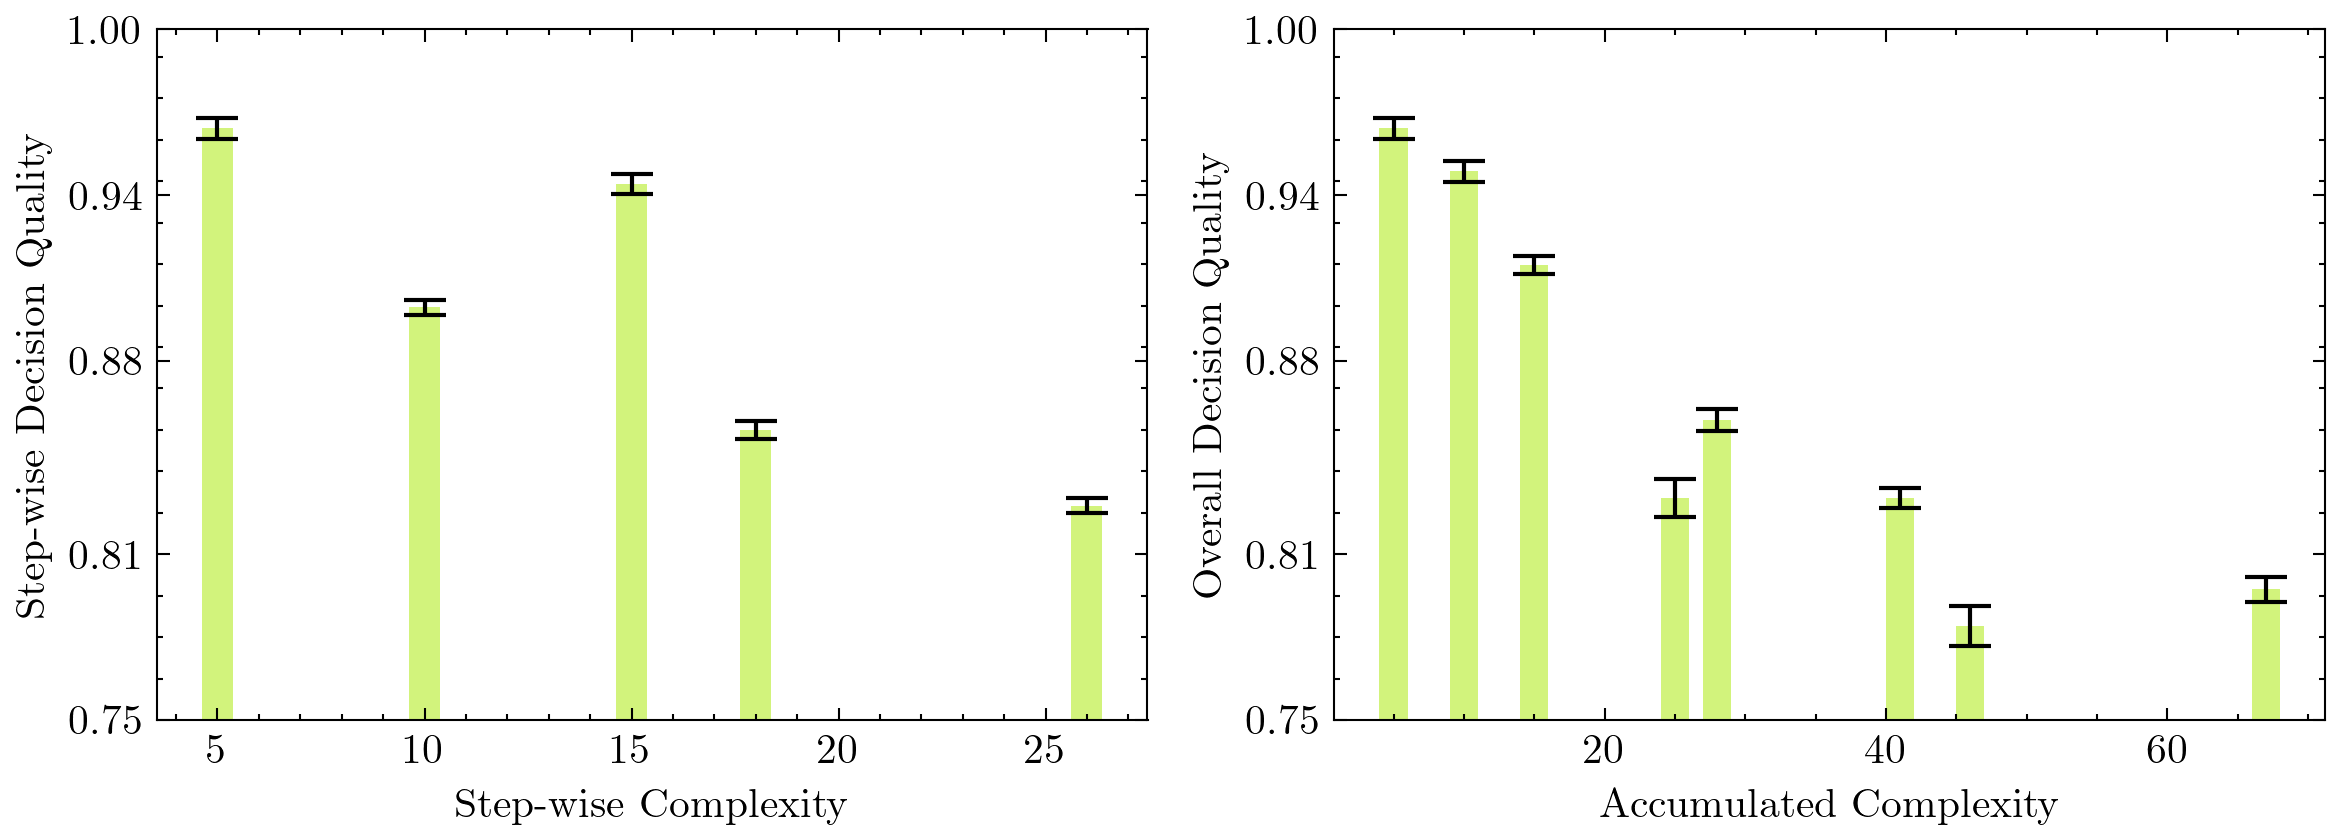

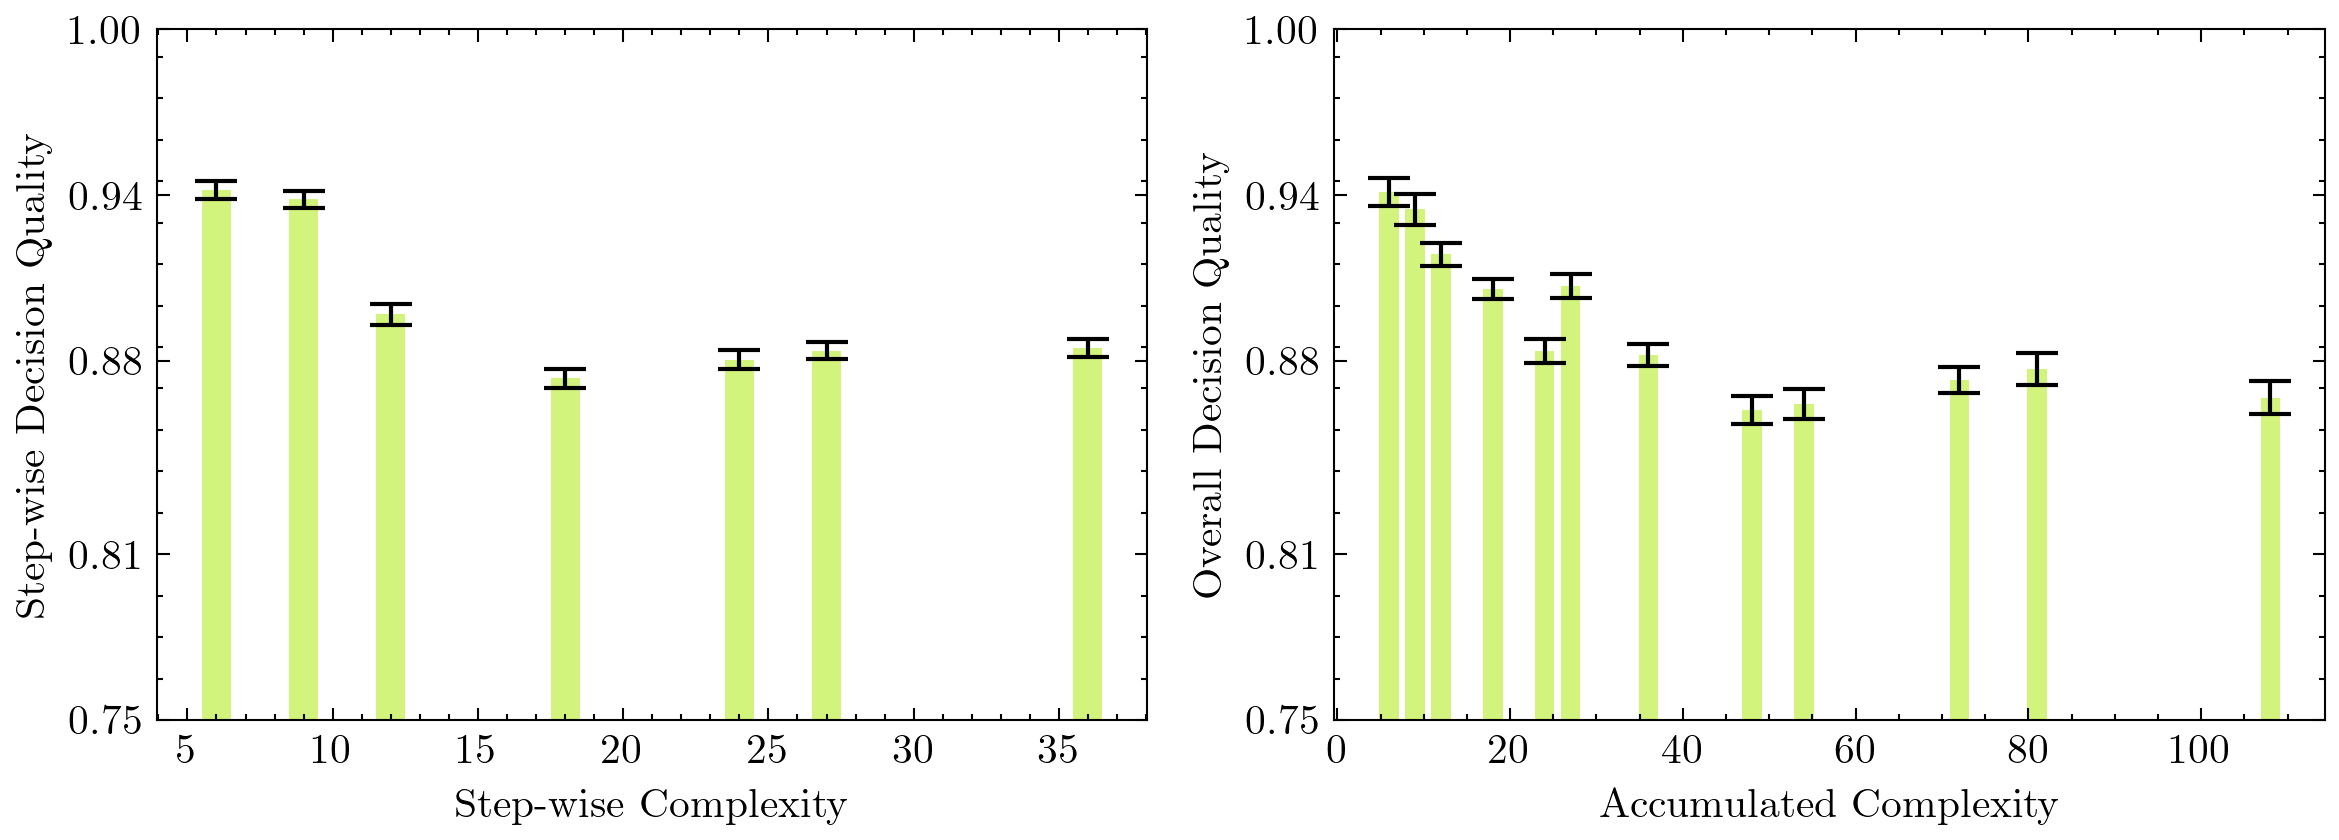

In [107]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_s', y_label='Step-wise Decision Quality', x_name='CC_u', x_label='Step-wise Complexity', out=False,axes=axes[0],ylimLow=0.75, ylimHigh=1,bar_width=0.75)
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Overall Decision Quality', x_name='ACC_u', x_label='Accumulated Complexity', out=False, axes=axes[1],ylimLow=0.75, ylimHigh=1,bar_width=2)
    fig.tight_layout()
    plt.savefig("images/State_DQ_CC.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_C_s', y_label='Step-wise Decision Quality', x_name='CC_c', x_label='Step-wise Complexity', out=False,axes=axes[0],ylimLow=0.75, ylimHigh=1,bar_width=1)
    twoAttributes_bar(participant_data, y_name='DQ_C_o', y_label='Overall Decision Quality', x_name='ACC_c', x_label='Accumulated Complexity', out=False, axes=axes[1],ylimLow=0.75, ylimHigh=1,bar_width=2.25)
    #regPlot(participant_data, x_name='ACC_c', y_name='DQ_C_o', title='Overall Decision Quality for Colour vs. Accumulated Urn Complexity',y_label='Overall Decision Quality for Colour', x_label='Accumulated Colour Complexity',axes=axes[1])
    
    fig.tight_layout()
    plt.savefig("images/Future_DQ_ACC.png")
    plt.show()

In [128]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3', 'DV_bayesInExp', 'abs_diff_U', 'abs_diff_C'],
      dtype='object')

## Boxplot where each data represent the average decision quality of a participant under each complexity level

In [223]:
def boxPlot(df, x_name, y_name, x_label, y_label, axes=plt, y_lim_lower=None, y_lim_upper=None):
    '''
    Create a box plot
    Every data point is averaged y for each participantID
    '''

    grouped_dataset = df.groupby(['participantID', x_name])[y_name].mean().reset_index()
    grouped_dataset[x_name] = grouped_dataset[x_name].astype(int)  
    sns.boxplot(x=x_name, y=y_name, data=grouped_dataset, ax=axes, palette=COLORS)
    axes.set_ylim(y_lim_lower, y_lim_upper)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)




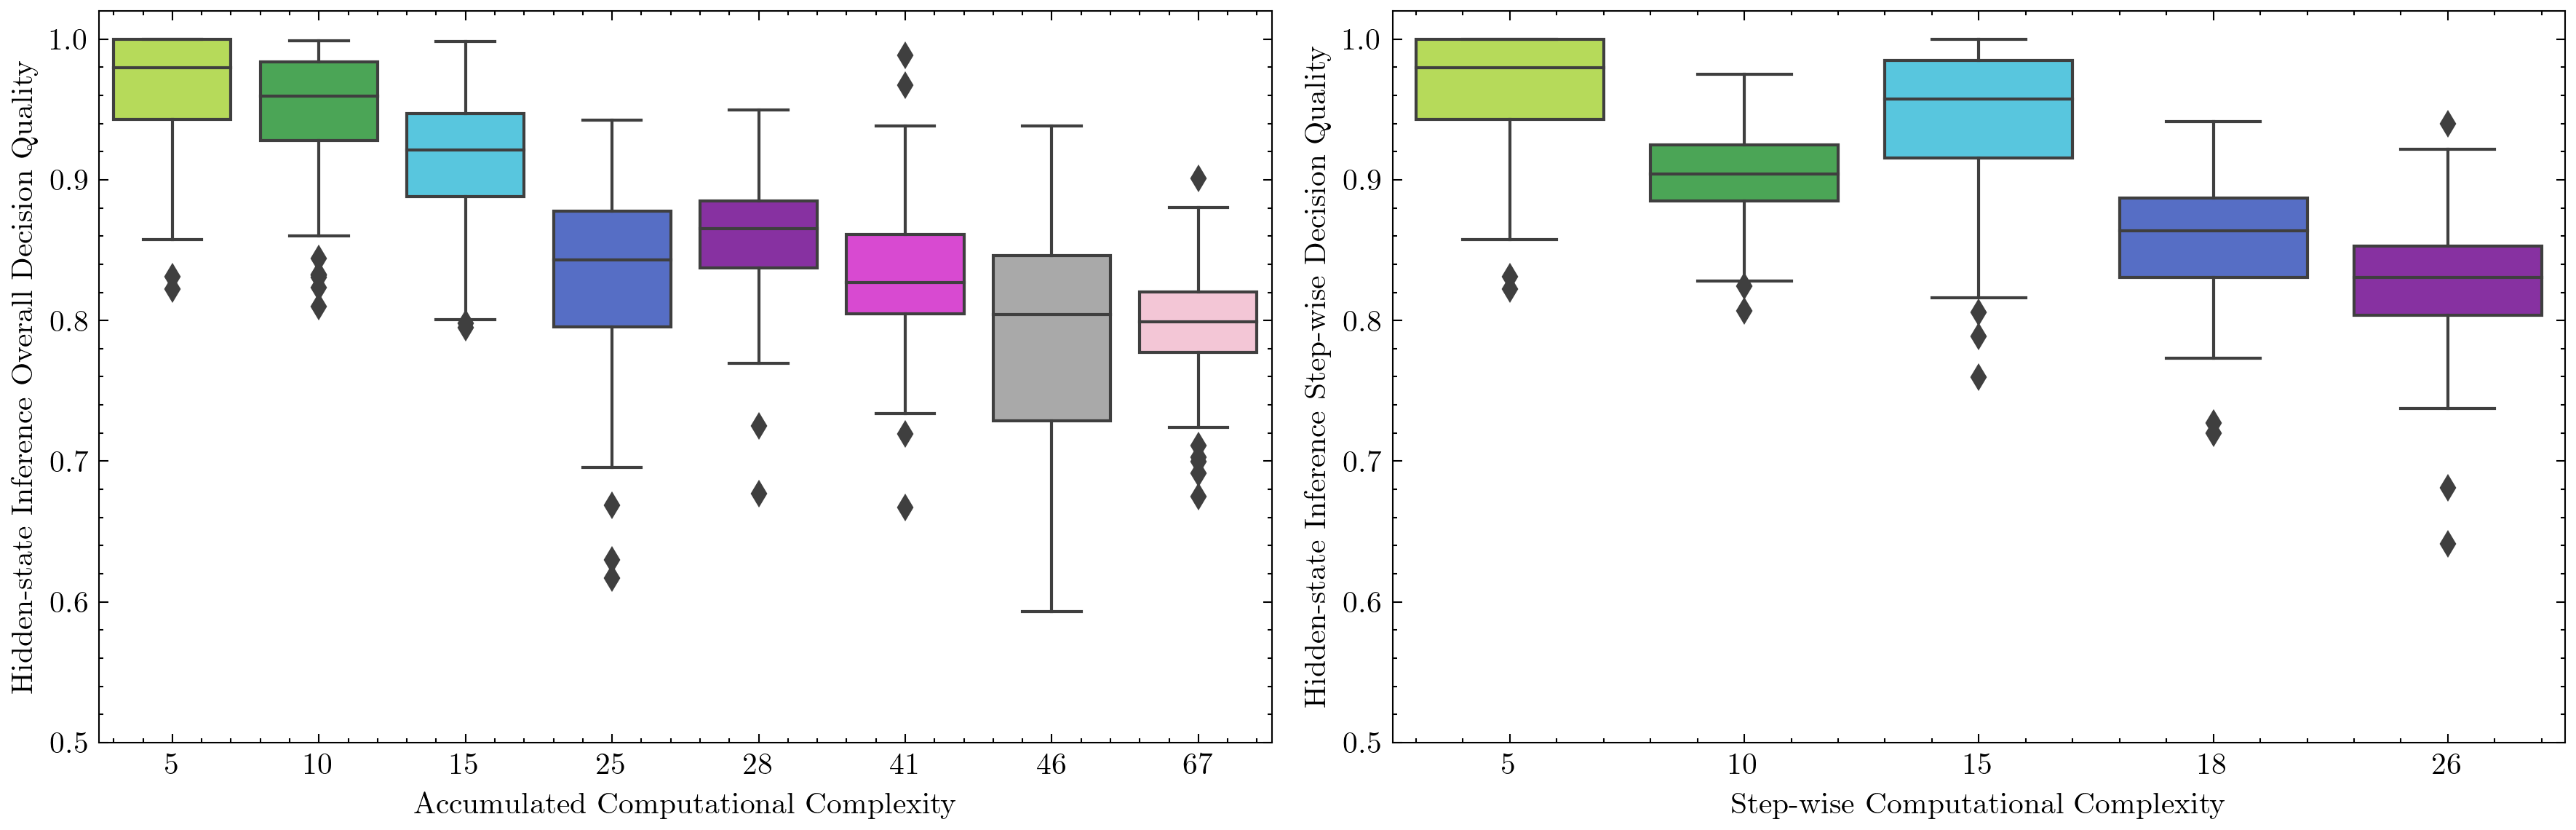

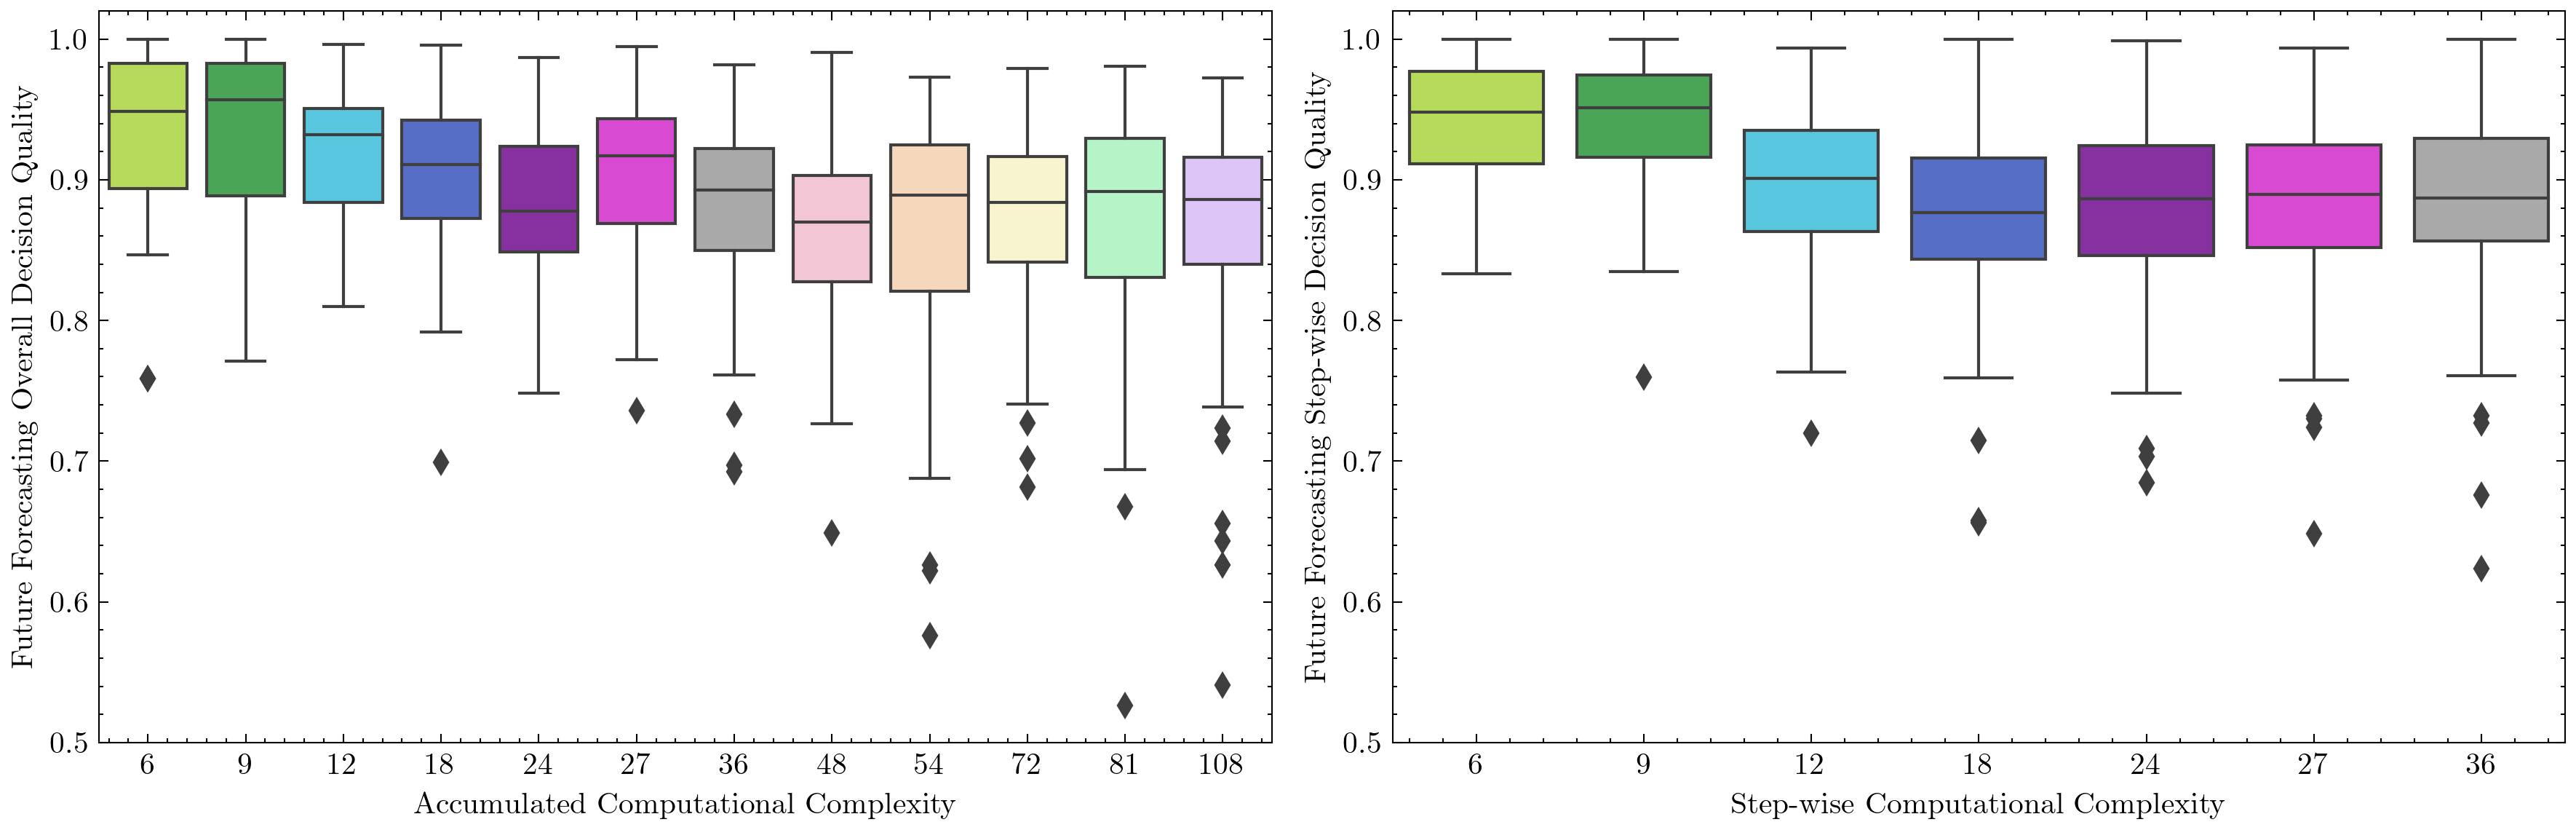

In [228]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    boxPlot(participant_data, x_name='ACC_u', y_name='DQ_U_o', x_label='Accumulated Computational Complexity', y_label='Hidden-state Inference Overall Decision Quality', axes=axes[0], y_lim_lower=0.5, y_lim_upper=1.02)
    boxPlot(participant_data, x_name='CC_u', y_name='DQ_U_s', x_label='Step-wise Computational Complexity', y_label='Hidden-state Inference Step-wise Decision Quality', axes=axes[1], y_lim_lower=0.5, y_lim_upper=1.02)
    
    fig.tight_layout()
    plt.savefig("images/Boxplot_state.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    boxPlot(participant_data, x_name='ACC_c', y_name='DQ_C_o', x_label='Accumulated Computational Complexity', y_label='Future Forecasting Overall Decision Quality', axes=axes[0], y_lim_lower=0.5, y_lim_upper=1.02)
    boxPlot(participant_data, x_name='CC_c', y_name='DQ_C_s', x_label='Step-wise Computational Complexity', y_label='Future Forecasting Step-wise Decision Quality', axes=axes[1], y_lim_lower=0.5, y_lim_upper=1.02)
    fig.tight_layout()
    plt.savefig("images/Boxplot_future.png")
    plt.show()

## Response Time

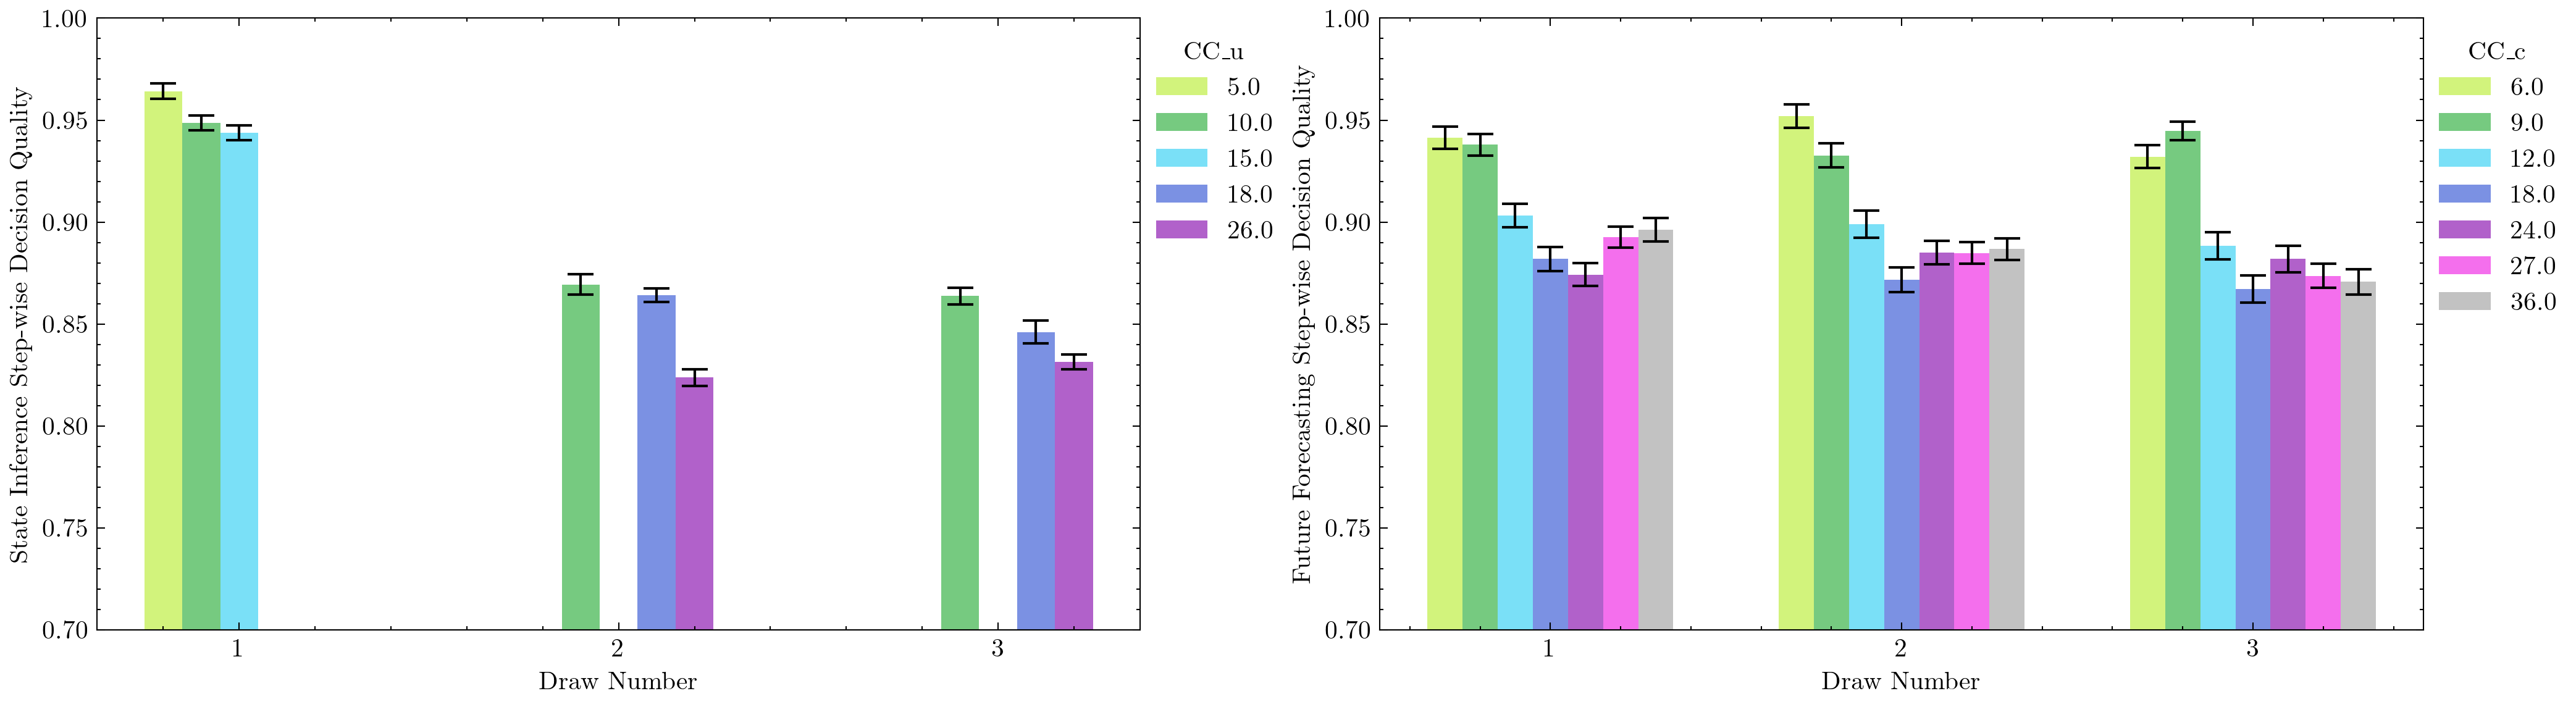

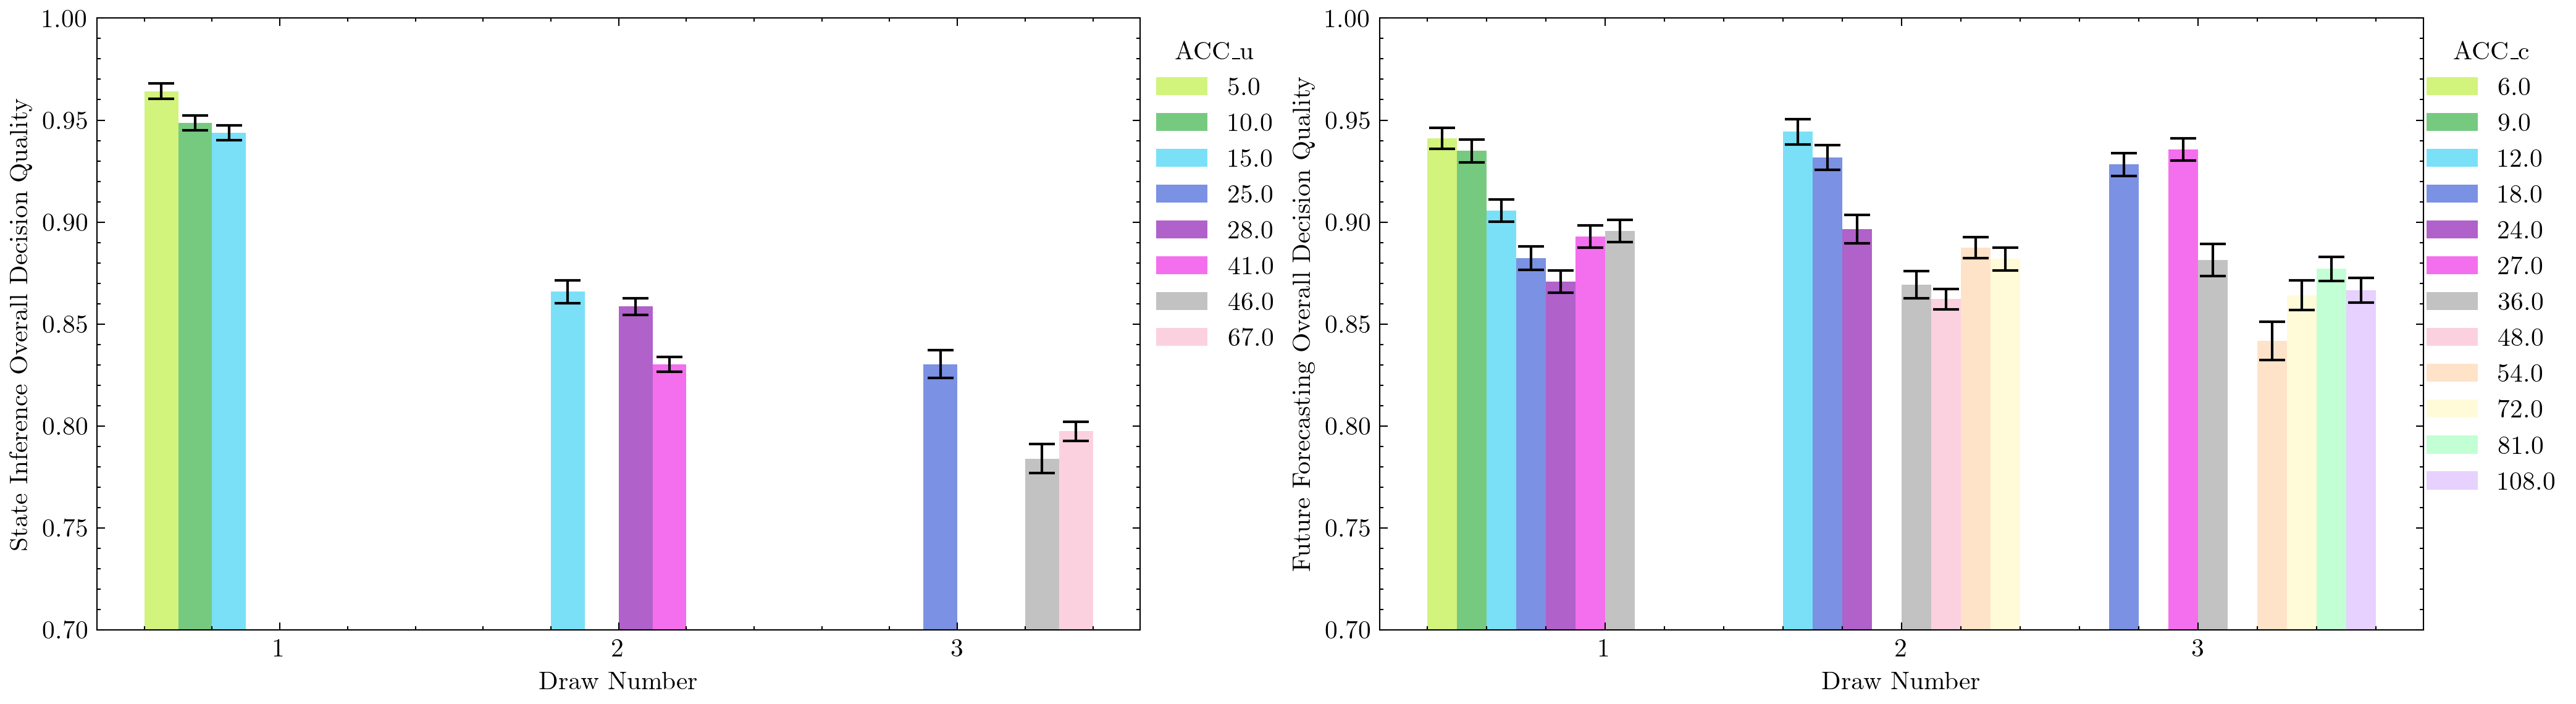

In [ ]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='CC_u', legend_title= "CC_u", y_name='DQ_U_s', 
                        y_label='State Inference Step-wise Decision Quality', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimLow=0.7, ylimHigh=1, out=False, ax=axes[0])
    threeAttributes_bar(participant_data, lengend_var='CC_c', legend_title= "CC_c", y_name='DQ_C_s', 
                        y_label='Future Forecasting Step-wise Decision Quality', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimLow=0.7, ylimHigh=1, out=False, ax=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQu_CC.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='ACC_u', legend_title= "ACC_u", y_name='DQ_U_o', 
                        y_label='State Inference Overall Decision Quality', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimLow=0.7, ylimHigh=1, out=False, ax=axes[0])
    threeAttributes_bar(participant_data, lengend_var='ACC_c', legend_title= "ACC_c", y_name='DQ_C_o',
                        y_label='Future Forecasting Overall Decision Quality', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimLow=0.7, ylimHigh=1, out=False, ax=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQc_CC.png")
    plt.show()

# Exploratory Analysis

## 1.relationships between demographic variables (age and gender) and the primary outcome measures of decision quality

gender is not balanced. Don't think I can claim anything about gender difference in Decision Quality Graphically
Age is discrete but multiple values so it is probably better to use regression to show this

## 2. relationships between decision quality, prior knowledge of statistics, and the utilization of Bayes’ rule in the experiment.

1. Use pie graph and bar graph to illustrate the prior knowledge of individuals. Bar Graph on used Bayes rule in exp: Group Never and Not Applicable to No, Sometimes and Always to Yes
2. Use regression to show the formal relationship: See regression 7 in frequentist model, nothing is significant

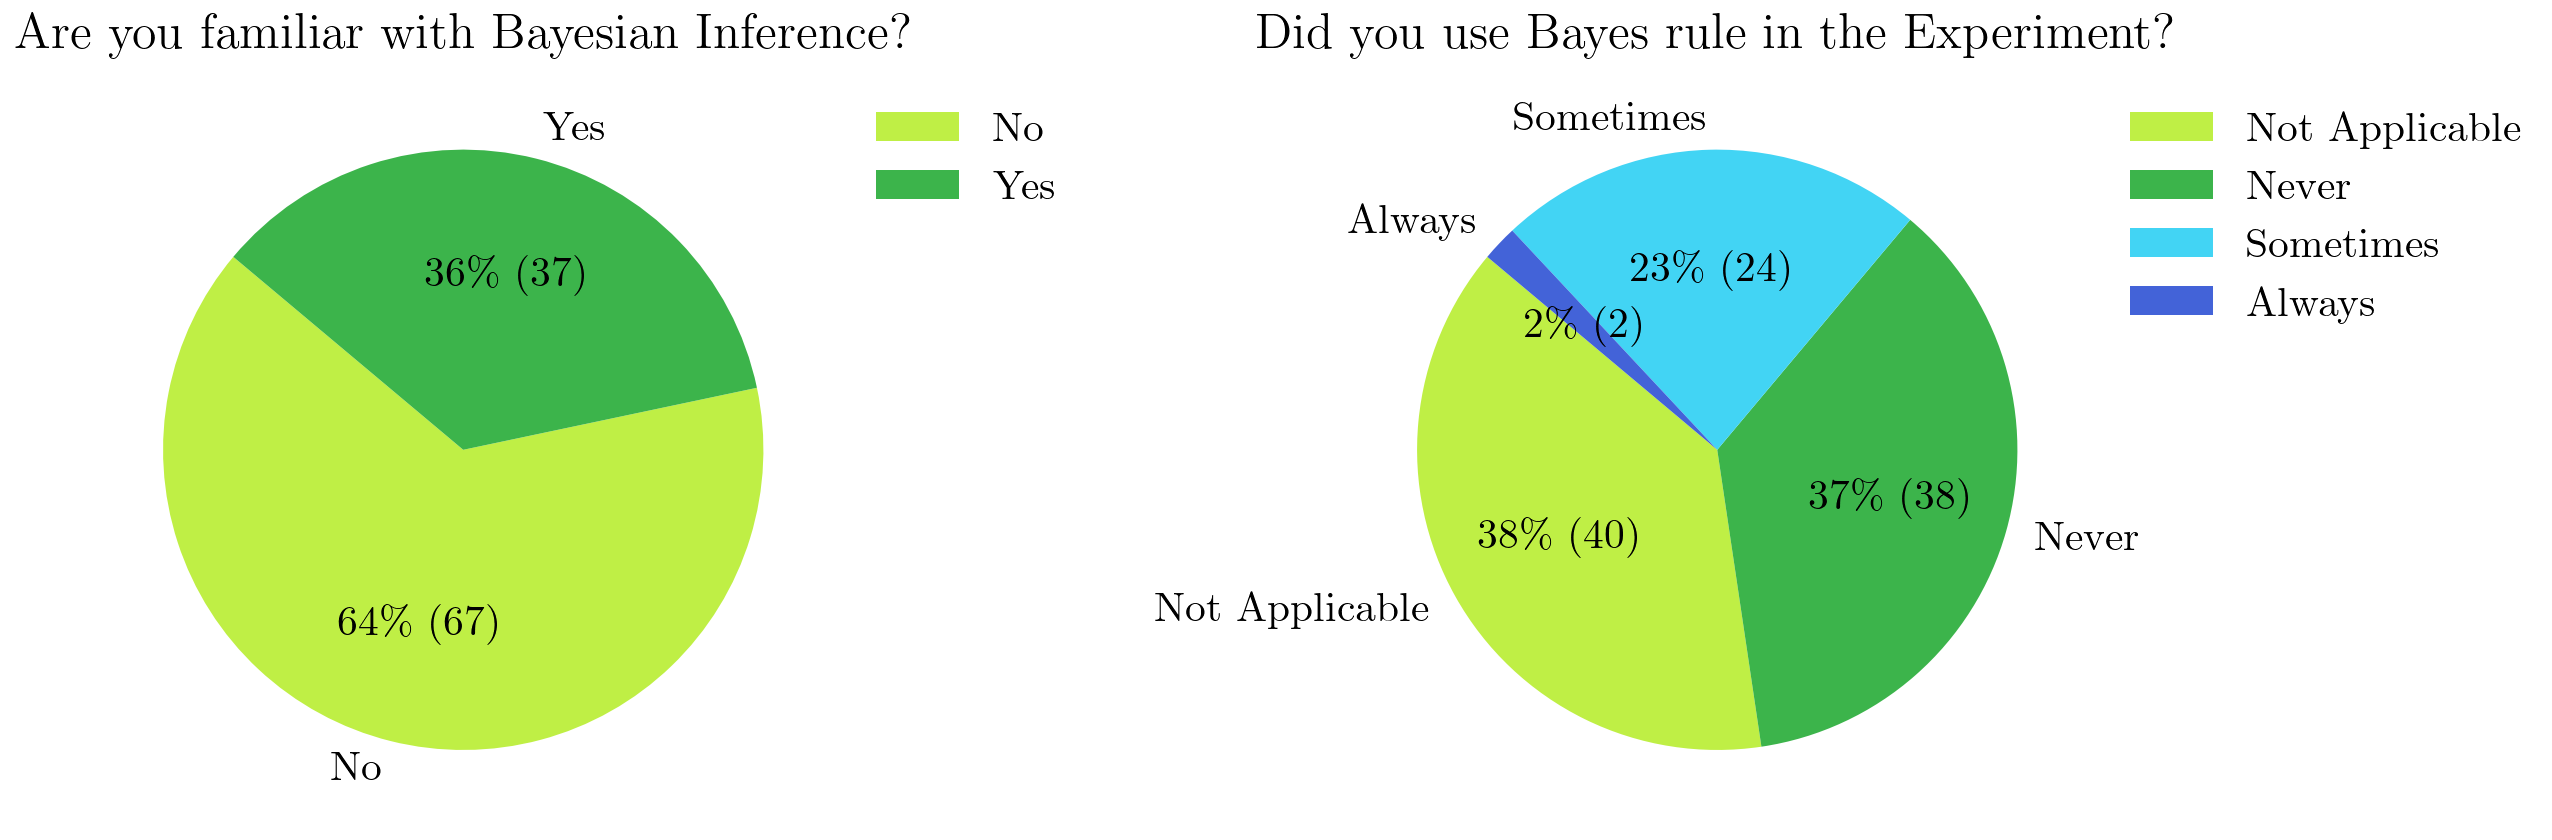

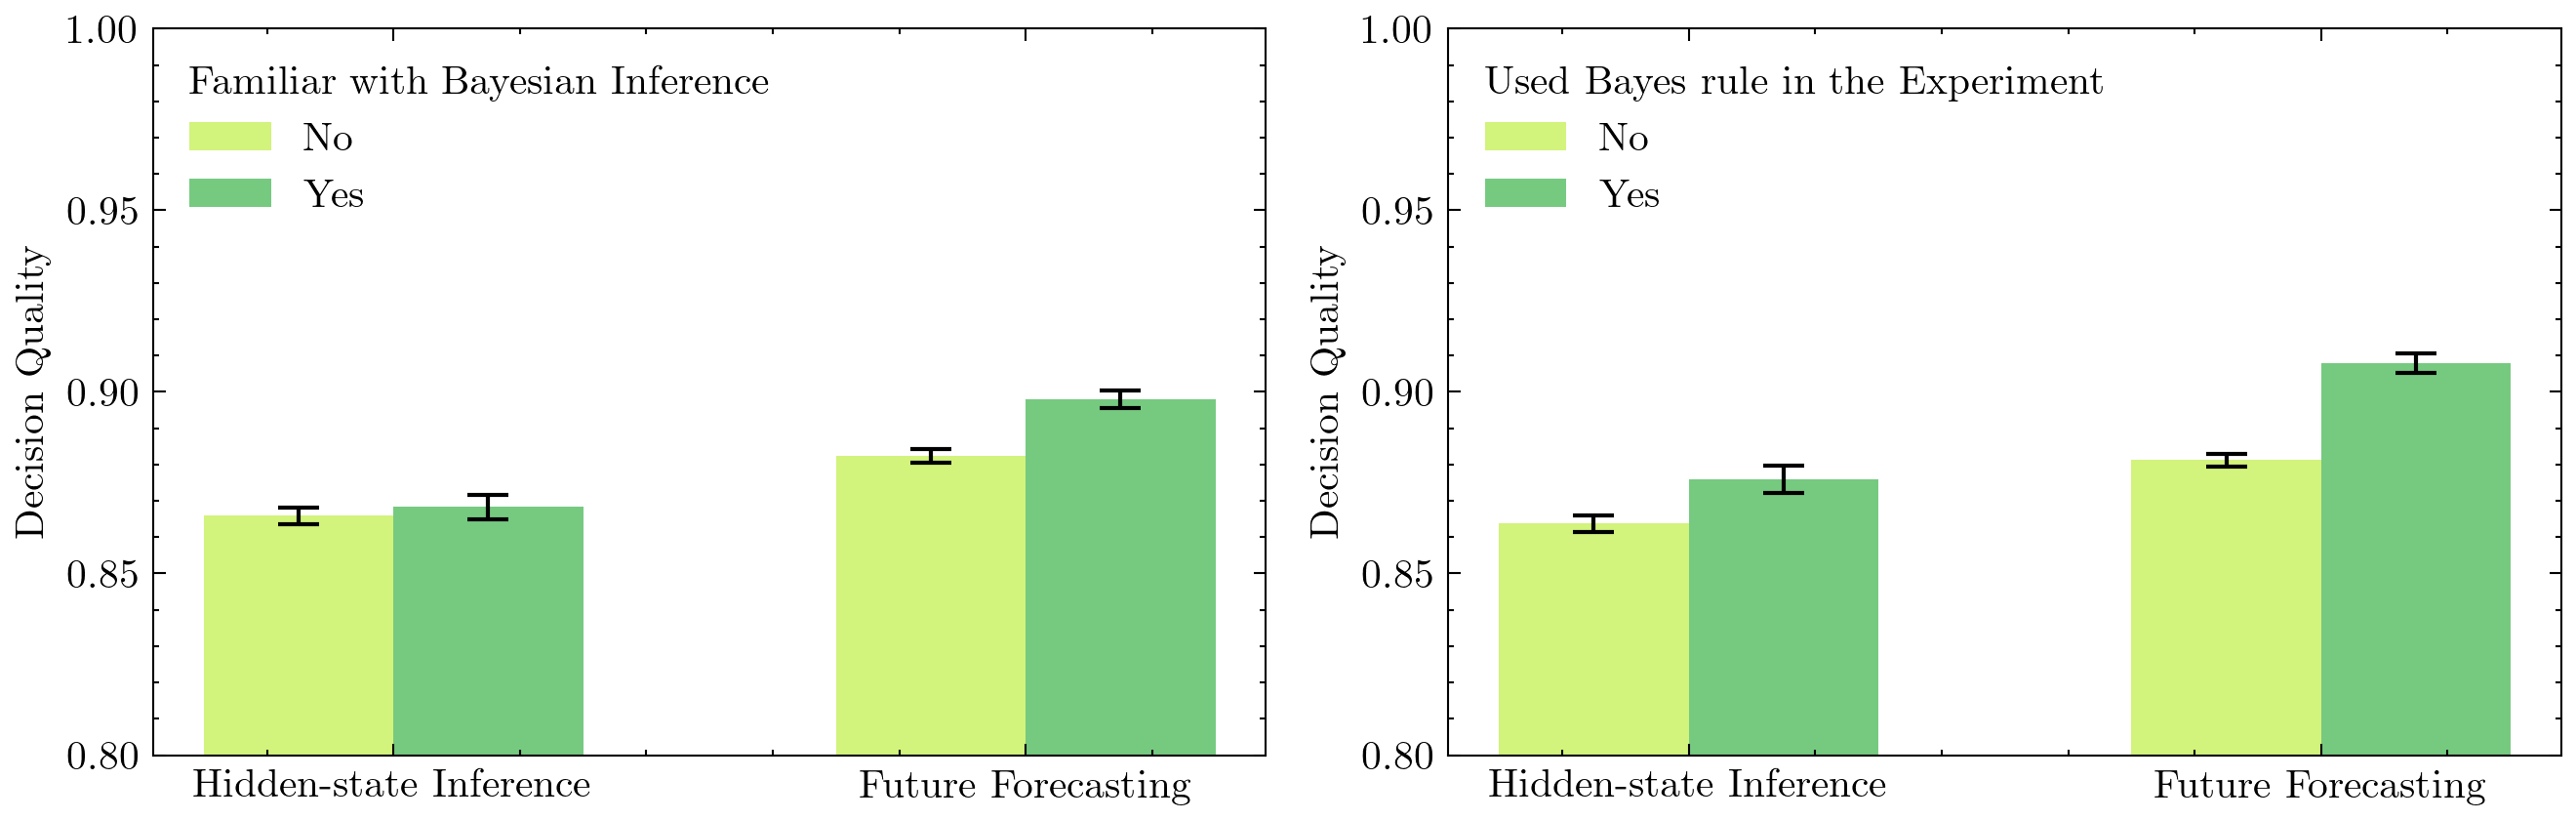

In [39]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

    pieChart(participant_data, 'bayesFamaliar', "Are you familiar with Bayesian Inference?", out=False, ax=axes[0])
    pieChart(participant_data, 'bayesInExp', "Did you use Bayes rule in the Experiment?", out=False, ax=axes[1])

    fig.tight_layout()
    plt.savefig("images/bayes_pie.png")     
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

    combTwoAttributes_bar(participant_data, y_name_1='DQ_U_o', y_label_1='Hidden-state Inference',
                           y_name_2='DQ_C_o', y_label_2='Future Forecasting', y_label_overall='Decision Quality',
                           x_name='bayesFamaliar', x_label='Familiar with Bayesian Inference', ylimLow=0.8, ylimHigh = 1.0, axes=axes[0])
        
    combTwoAttributes_bar(participant_data, y_name_1='DQ_U_o', y_label_1='Hidden-state Inference',
                           y_name_2='DQ_C_o', y_label_2='Future Forecasting', y_label_overall='Decision Quality',
                           x_name='DV_bayesInExp', x_label='Used Bayes rule in the Experiment', ylimLow=0.8, ylimHigh = 1.0, axes=axes[1])
    # combTwoAttributes_bar(participant_data, y_name_1='DQ_U_o', y_label_1='Hidden-state Inference',
    #                        y_name_2='DQ_C_o', y_label_2='Future Forecasting', y_label_overall='Decision Quality',
    #                        x_name='sex', x_label='Sex', ylimLow=0.8, ylimHigh = 1.0, axes=axes[1,0])
    # combTwoAttributes_bar(participant_data, y_name_1='DQ_U_o', y_label_1='Hidden-state Inference',
    #                        y_name_2='DQ_C_o', y_label_2='Future Forecasting', y_label_overall='Decision Quality',
    #                        x_name='age', x_label='Age', ylimLow=0.8, ylimHigh = 1.0, axes=axes[1,1])
    fig.tight_layout()
    plt.savefig("images/bayes_bar.png")     
    plt.show()



## 3. relationships between response time and computational complexity 

1. Bar graph on Average RT Vs each complexity level and ball draw seq
2. Bar graph on Average RT Vs ball draw seq
3. regression on RT vs ball draw seq and RT vs ball draw seq and complexity control for instance ID and participant ID

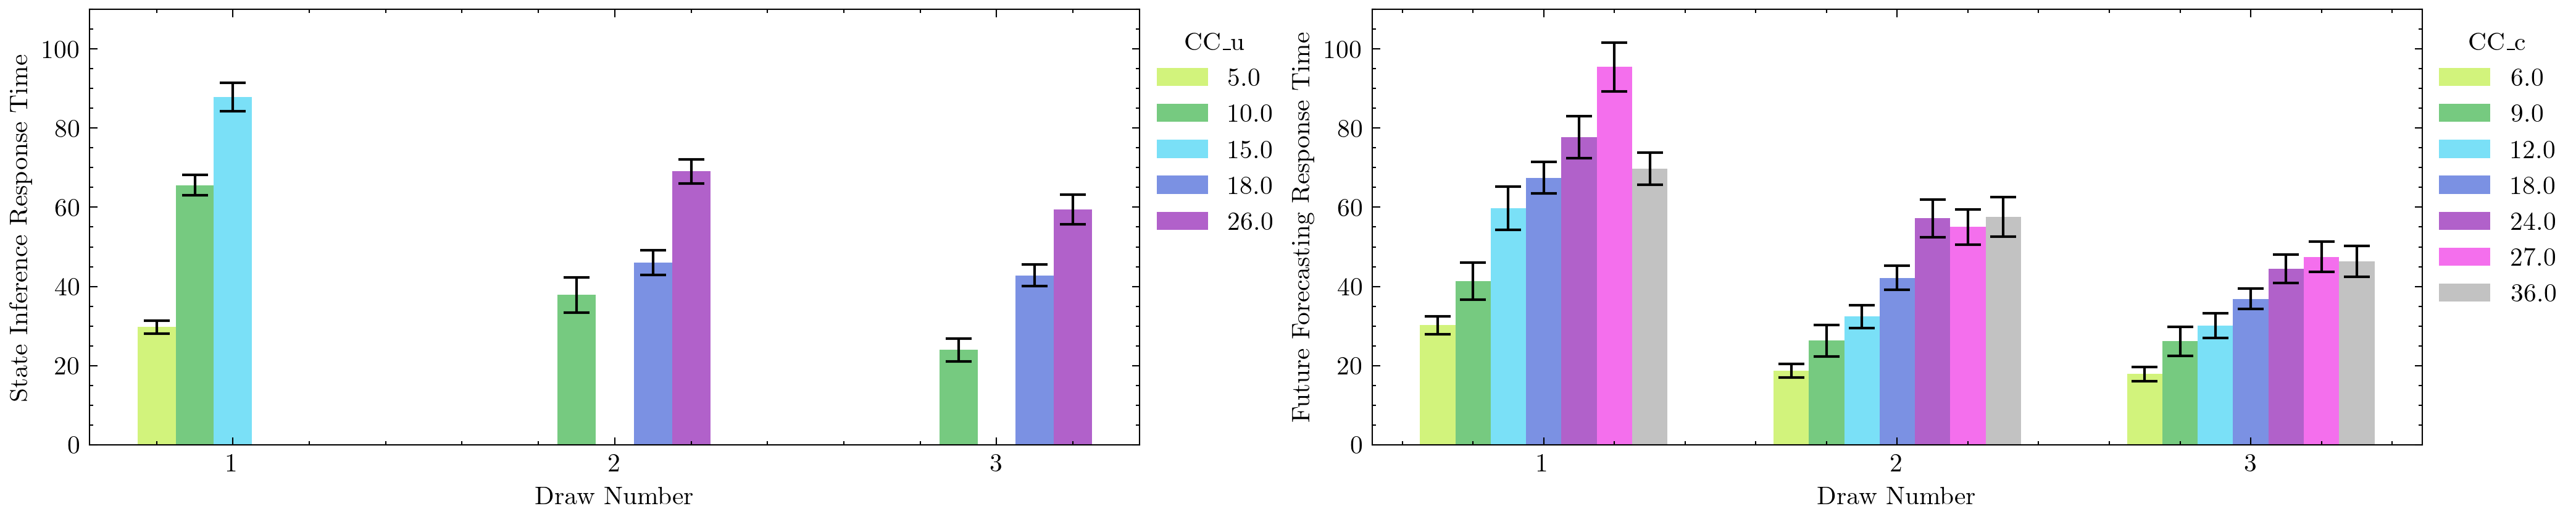

In [84]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 3), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='CC_u', legend_title= "CC_u", y_name='responseTimeUrn', 
                        y_label='State Inference Response Time', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimHigh=110, out=False, ax=axes[0])
    threeAttributes_bar(participant_data, lengend_var='CC_c', legend_title= "CC_c", y_name='responseTimeColour', 
                        y_label='Future Forecasting Response Time', x_name='seqBall', x_label='Draw Number', 
                        bar_width=0.1, ylimHigh=110, out=False, ax=axes[1])
    fig.tight_layout()
    plt.savefig("images/RT_CC.png")
    plt.show()


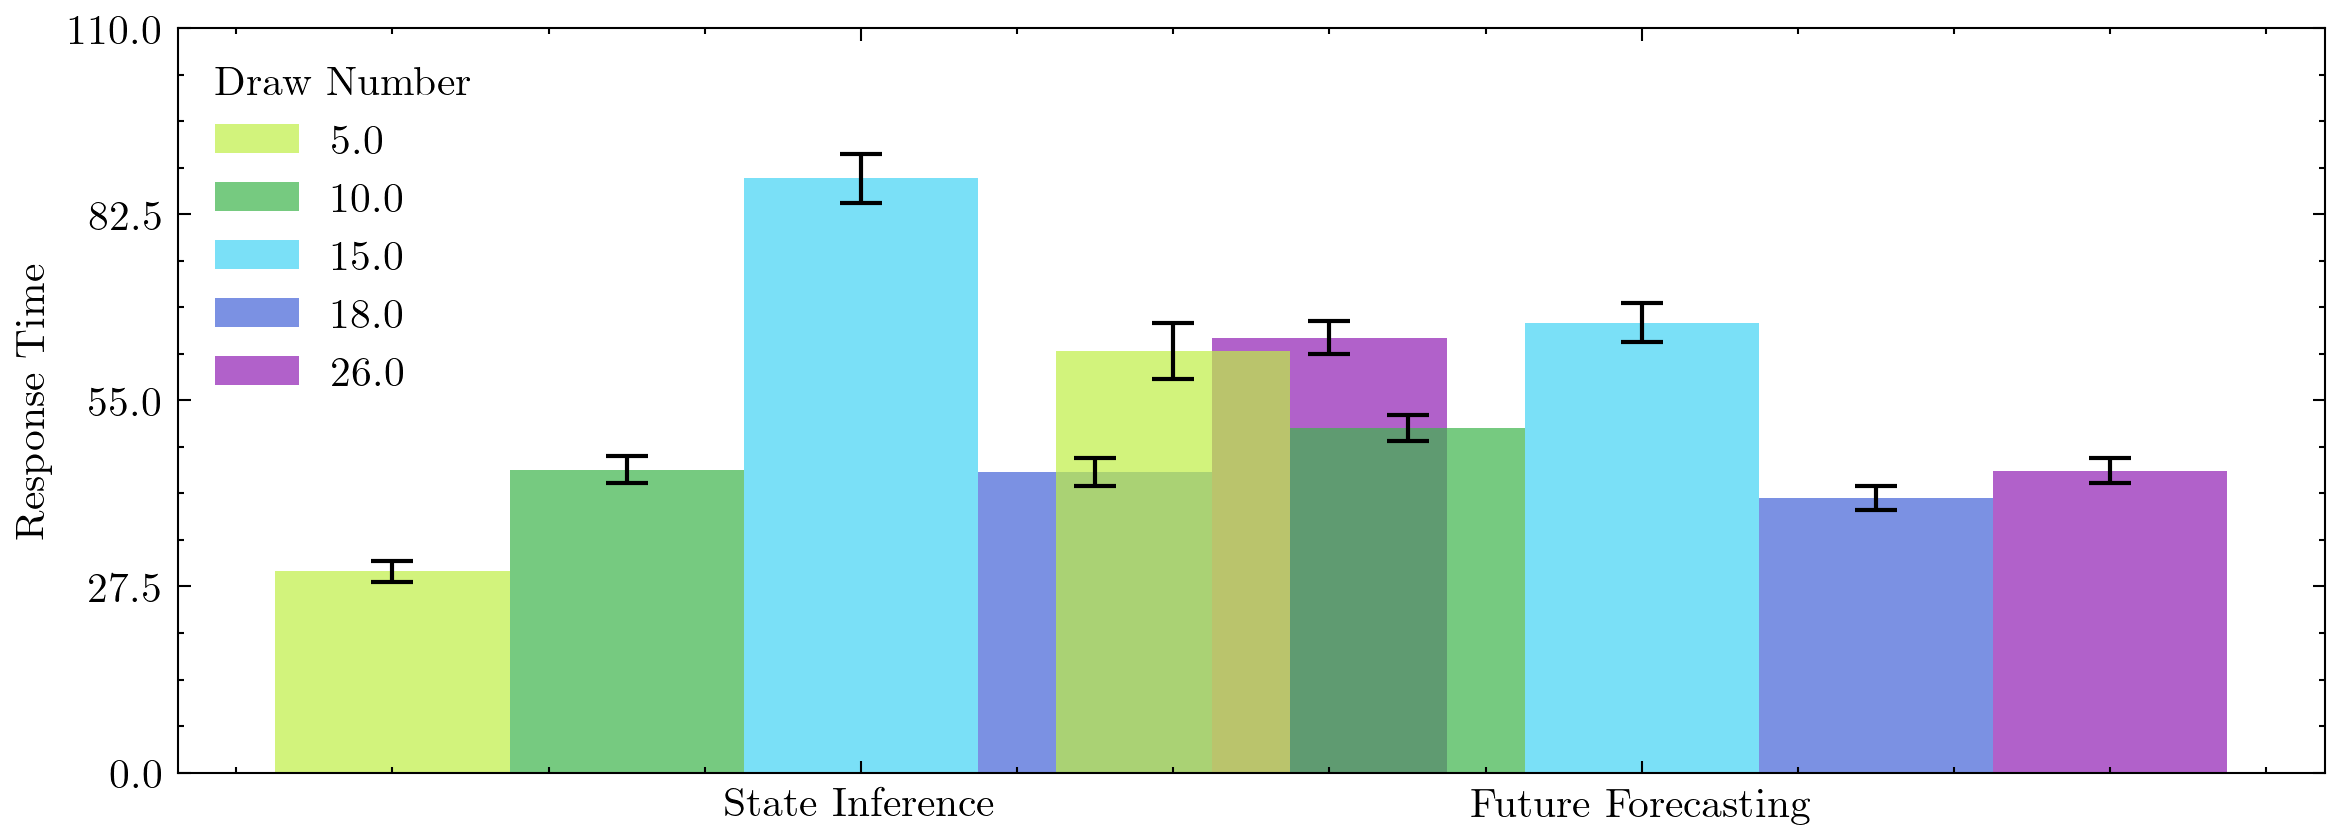

In [62]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 1, figsize=(8, 3), dpi=300)

    combTwoAttributes_bar(participant_data, y_name_1='responseTimeUrn', y_label_1='State Inference',
                           y_name_2='responseTimeColour', y_label_2='Future Forecasting', y_label_overall='Response Time',
                           x_name='CC_u', x_label='Draw Number', ylimLow=0, ylimHigh = 110, axes=axes)

    fig.tight_layout()
    plt.savefig("images/RT_draw_bar.png")     
    plt.show()

## 4. Interaction on complexity and response time?
r13, r14 frequentist